In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import make_grid

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
pretrained_model = "googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#             ])), 
#         batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [5]:
def im_is_black(image):
    if image < torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [6]:
def im_is_white(image):
    if image >= torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [7]:
def character_search(image):
    image_copy = copy.deepcopy(image)
    for x in range(64):
        for y in range(64):
            if im_is_black(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if i != 0 and j != 0:
                            continue
                        elif (x + i != -1) and (x + i != 64) and (y + j != -1) and (y + j != 64):
                            if im_is_white(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
            elif im_is_white(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if i != 0 and j != 0:
                            continue
                        elif (x + i != -1) and (x + i != 64) and (y + j != -1) and (y + j != 64):
                            if im_is_black(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
    image_chain = list(itertools.chain.from_iterable(image_copy))
    return image_chain

In [8]:
def attack(data, data_grad, target, dirname_res, dirname_pro, chr, count, epsilon, lim, success):
    os.makedirs(dirname_pro + chr + "/{}".format(count), exist_ok=True)
    # os.makedirs(dirname_pro + chr + "/{}".format(i), exist_ok=True)
    for i in range(1, 1001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        # perturbed_data += (perturbed_data < torch.Tensor([1 - lim]).to("cuda")) * epsilon + (perturbed_data < torch.Tensor([0]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([-1 + lim]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([0]).to("cuda")) * epsilon
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_pro + chr + "/{}".format(count) + "/" + "{}.png".format(i), data.squeeze().detach().cpu().numpy(), cmap="gray")
        if pred.item() != target.item():
            success += 1
            break
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    os.makedirs(dirname_res + chr + "/{}".format(i), exist_ok=True)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imsave(dirname_res + chr + "/{}".format(i) + "/" + "{}.png".format(count), data.squeeze().detach().cpu().numpy(), cmap="gray")
    return data, pred, success

In [9]:
img_size = 64 # Image size
batch_size = 16  # Batch size

# Model
z_size = 100
ngf = 32
ndf = 64
generator_layer_size = [256, 512, 1024, 2048]
discriminator_layer_size = [2048, 1024, 512, 256]

# Training
epochs = 100 # Train epochs
learning_rate_G = 2e-5
learning_rate_D = 1e-5

In [10]:
class_list = [chr(i + 65) for i in range(26)]
class_num = len(class_list)

In [11]:
def onehot_encode(label, n_class=26):  
    # ラベルをOne-Hoe形式に変換
    eye = torch.eye(n_class).to(device)
    # ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして戻す
    return eye[label].view(-1, n_class, 1, 1)
    
def concat_image_label(image, label, n_class=26):
    # 画像とラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)       # ラベルをOne-Hot形式に変換
    oh_label = oh_label.expand(16, n_class, 64, 64)  # ラベルを画像サイズに拡大
    return torch.cat((image, oh_label), dim=1)    # 画像とラベルをチャネル方向（dim=1）で連結
 
def concat_noise_label(noise, label, n_class=26):
    # ランダムベクトルとラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)     # ラベルをOne-Hot形式に変換
    return torch.cat((noise, oh_label), dim=1)  # ランダムベクトルとラベルを連結

In [12]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        # z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        # c = self.label_emb(labels)
        
        # Concat image & label
        # x = torch.cat([z, c], 1)

        x = concat_noise_label(z, labels)


        # rlabels_list = []
        # for label in rlabels:
        #     l = torch.Tensor([[[label.item()]]])
        #     rlabels_list.append(l)
        # rlabels_list = torch.stack(rlabels_list).to(device)

        # x = torch.cat((x, rlabels_list), dim=1)
        
        # Generator out
        out = self.model(x)
        
        return out
        # return out.view(-1, self.img_size, self.img_size)

In [13]:
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
generator.load_state_dict(torch.load("../GAN+classifier_c1e-6/model/18.pth", map_location='cpu'))

<All keys matched successfully>

In [14]:
def test( model, device):
    chr_lambda = lambda a: chr(a + 65)
    dirname_grad = "../GAN+classifier_c1e-6" + "/grad/"
    dirname_org = "../GAN+classifier_c1e-6" + "/org/"
    dirname_adv = "../GAN+classifier_c1e-6" + "/adv/"
    dirname_res = "../GAN+classifier_c1e-6" + "/resistance/"
    dirname_pro = "../GAN+classifier_c1e-6" + "/progress/"
    for c in [chr(i) for i in range(65, 65+26)]:
        os.makedirs(dirname_grad + c, exist_ok=True)
        os.makedirs(dirname_org + c, exist_ok=True)
        os.makedirs(dirname_adv + c, exist_ok=True)
        os.makedirs(dirname_res + c, exist_ok=True)
        os.makedirs(dirname_pro + c, exist_ok=True)
        for d in [chr(i) for i in range(65, 65+26)]:
            os.makedirs(dirname_adv + c + "/" + c + "→" + d, exist_ok=True)


    # class ImageTransform():
    #     def __init__(self, mean, std):
    #         self.data_transform = transforms.Compose([
    #         transforms.Grayscale(),
    #         transforms.ToTensor(),
    #         transforms.Resize((64, 64)),
    #         transforms.Normalize(mean, std)
    #         ])

    #     def __call__(self, img):
    #         return self.data_transform(img)
    # mean = (0.5,)
    # std = (0.5,)
    # images_test = ImageFolder( "../GoogleFonts/test", transform = ImageTransform(mean, std))
    # batch_size = 1
    # test_loader = DataLoader(images_test, batch_size = batch_size, shuffle = False, drop_last=True)

    for alphabet in range(1, 26):
        z = Variable(torch.randn(2200, z_size, 1, 1)).to(device)

        # Labels 0 ~ 9
        labels = Variable(torch.LongTensor(np.zeros(2200) + alphabet)).to(device)
        sample_images = generator(z, labels).data.to("cpu")

        # sample_images = sample_images.data.cpu()
        # grid = make_grid(sample_images, nrow=26, normalize=True).permute(1,2,0).numpy()
        # fig, ax = plt.subplots(figsize=(26,26))
        # plt.imshow(grid)
        # plt.show()

        # 精度カウンター
        correct = 0
        success = 0
        # count = 0
        count_list = [0] * 26

        adv_examples = []
        # i=0
        a_list = []
        # テスト用データセット内の全てのサンプルをループします
        for data, target in tqdm(zip(sample_images, labels), total = 2200):

            if count_list[target.item()] == 2000:
                continue

            # i+=1
            # if i==150:
            #     break
            # データとラベルをデバイス（CPUもしくはGPU）に送信します
            data, target = data.unsqueeze(0).to(device), target.unsqueeze(0).type(torch.LongTensor).to(device)
            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。

            data.requires_grad = True

            # データをモデルに順伝播させます
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

            # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
            
            if init_pred.item() != target.item():
                continue

            correct += 1

            data_copy = data.detach().clone()
            # character_coordinate = character_search(data_copy.data[0][0])

            count_list[init_pred.item()] += 1
        
            # 損失を計算します
            loss = F.nll_loss(output, target)
            # 既存の勾配を全てゼロにします
            model.zero_grad()
            # 逆伝播させてモデルの勾配を計算します
            loss.backward()
            # データの勾配を取得します
            data_grad = data.grad.data
            
            max_index = []
            # # 勾配のヒートマップ
            # grad_map = data_grad.squeeze().detach().cpu().numpy()
            # grad_map_abs = np.abs(grad_map)
            # plt.xticks([], [])
            # plt.yticks([], [])
            # plt.imsave(dirname_grad + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), grad_map_abs, cmap="Reds")

            perturbed_data, pred, success = attack(data, data_grad, target, dirname_res, dirname_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.02, 0, success)
    
            final_pred = pred

            org = data_copy.squeeze().detach().cpu().numpy()
            adv = perturbed_data.squeeze().detach().cpu().numpy()

            #各条件を満たす画像の保存
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_org + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), org, cmap="gray")
            
            os.makedirs(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/", exist_ok=True)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), adv, cmap="gray")

    # print(success)
    # print("Test Accuracy = {} / 30862 = {}".format(correct, correct / 30862))
    # print("Attack Success = {} / {} = {}".format(success, correct, success / correct))
    
        # if (final_pred.item() != target.item()):
        #     # あとで可視化するために敵対的サンプルのうちいくつかを保存
        #     if len(adv_examples) < 25:
        #         adv_examples.append( (init_pred.item(), final_pred.item(), org, adv))
                # if len(adv_examples) == 25:
                #     break


        # # epsilonごとの最終的な精度を算出
        # final_acc = correct/float(len(test_loader))
        # print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

        # # 精度と敵対的サンプルを返却
        # return final_acc, adv_examples

100%|██████████| 2200/2200 [04:05<00:00,  8.96it/s]


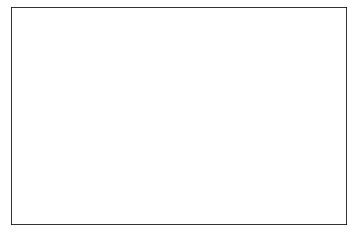

In [15]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
test(model, device)

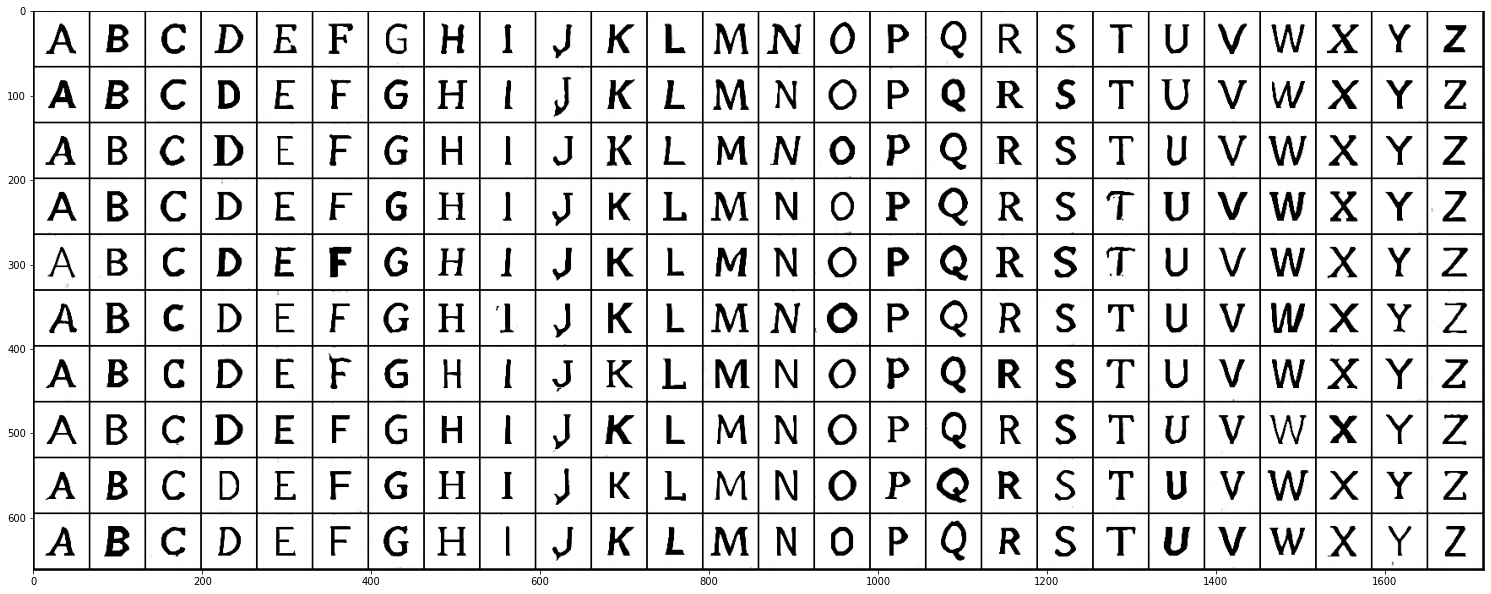

In [16]:
z = Variable(torch.randn(260, z_size, 1, 1)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(class_num)])).to(device)
sample_images = generator(z, labels)
sample_images = generator(z, labels).data.to("cpu")
grid = make_grid(sample_images, nrow=26, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(26,26))
plt.imshow(grid)
plt.savefig("../GAN+classifier_c1e-6/sample.png")
plt.show()

In [17]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv, org_ex, adv_ex = examples[0][j]
    plt.title("{}".format(orig), color="white")
    plt.imshow(org_ex, cmap="gray")
plt.tight_layout()
plt.show()

IndexError: list index out of range

<Figure size 576x720 with 0 Axes>

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, org_ex, adv_ex = examples[0][j]
    plt.title("{} -> {}".format(orig, adv), color="white")
    plt.imshow(adv_ex, cmap="gray")
plt.tight_layout()
plt.show()